In [13]:
import os
import cv2
import json
import math
import sys
import numpy as np
from pathlib import Path
from typing import Dict, List, Tuple
from collections import defaultdict, Counter
from matplotlib import pyplot as plt

# Add parent directory to path for utils import
sys.path.insert(0, str(Path.cwd().parent))
from utils.file_dialog_utils import pick_folder

In [ ]:
# --- USER CONFIGURATION ---

# User Inputs
screenshot_dir = Path(pick_folder(title="Select screenshots folder"))
zero_template_folder = Path(pick_folder(title="Select pocket 0 templates folder"))

GEOMETRY_JSON = "C:\\Users\\Gabriel\\Documents\\Dissertation\\Code\\notebooks\\pipeline_attempts\\roulette_cv4\\wheel_geometry.json"                   # produced by setup.ipynb
EVENTS_PATH = "C:\\Users\\Gabriel\\Documents\\Dissertation\\Code\\notebooks\\pipeline_attempts\\roulette_cv4\\inference_output\\results_events.jsonl"  # produced by inference.ipynb

# Detection settings
MIN_ZERO_MATCH_SCORE = 0.60
PHASE_OFFSET_POCKETS = 0.0
CLOCKWISE = True

# Outputs
OUTPUT_DIR = "pocket_detection_output"
RESULTS_JSONL_PATH = os.path.join(OUTPUT_DIR, "results_events.jsonl")

# Other constants
# European Roulette wheel pocket sequence (37 pockets: 0-36)
# Starting from 0 and going clockwise
EU_WHEEL_SEQUENCE = [
    0, 32, 15, 19, 4, 21, 2, 25, 17, 34, 6, 27, 13, 36, 11, 30, 8, 23, 10,
    5, 24, 16, 33, 1, 20, 14, 31, 9, 22, 18, 29, 7, 28, 12, 35, 3, 26
]

In [15]:
# --- OUTPUT DIRECTORY SETUP ---

Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
print("OUTPUT_DIR:", Path(OUTPUT_DIR).resolve())

OUTPUT_DIR: C:\Users\Gabriel\Documents\Dissertation\Code\notebooks\roulette_cv4\pocket_detection_output


In [16]:
# --- DATA LOADING FUNCTIONS ---

def load_wheel_geometry(json_path: Path) -> Dict:
    """Load wheel geometry from JSON file."""
    with open(json_path, 'r') as f:
        return json.load(f)


def load_results_events(jsonl_path: Path) -> List[Dict]:
    """Load ball landing events from JSONL file."""
    events = []
    with open(jsonl_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line:
                events.append(json.loads(line))
    return events

In [17]:
# --- CORE ALGORITHM: COORDINATE TRANSFORMATION ---

def pixel_to_ellipse_angle(
    px: float, 
    py: float, 
    cx: float, 
    cy: float, 
    rx: float, 
    ry: float, 
    rotation_deg: float
) -> float:
    """
    Convert pixel coordinates to angle around an ellipse.
    
    Steps:
    1. Translate point to ellipse center origin
    2. Rotate to align with axis (compensate for ellipse rotation)
    3. Normalize by radii to get unit circle
    4. Compute angle using atan2
    
    Args:
        px, py: Pixel coordinates of the ball
        cx, cy: Ellipse center coordinates
        rx, ry: Ellipse radii (semi-major and semi-minor axes)
        rotation_deg: Ellipse rotation in degrees
    
    Returns:
        Angle in radians [0, 2π)
    """
    # Step 1: Translate to ellipse center
    dx = px - cx
    dy = py - cy
    
    # Step 2: Rotate to align with ellipse axes
    # Convert rotation to radians (negative because we're rotating coordinate system)
    rotation_rad = -math.radians(rotation_deg)
    cos_r = math.cos(rotation_rad)
    sin_r = math.sin(rotation_rad)
    
    # Rotate point
    x_local = dx * cos_r - dy * sin_r
    y_local = dx * sin_r + dy * cos_r
    
    # Step 3: Normalize by radii (transform ellipse to circle)
    x_norm = x_local / rx
    y_norm = y_local / ry
    
    # Step 4: Compute angle
    # atan2 returns [-π, π], convert to [0, 2π)
    angle = math.atan2(y_norm, x_norm)
    if angle < 0:
        angle += 2 * math.pi
    
    return angle


def angle_to_pocket_index(
    angle_rad: float,
    reference_angle_rad: float,
    num_pockets: int,
    clockwise: bool = True,
    phase_offset_pockets: float = 0.0,
) -> int:
    """
    Map angle to nearest pocket index (center-based), rather than floor-based binning.

    phase_offset_pockets lets you apply a constant global correction like:
      +0.0 (default)
      +0.5 (if your reference is a boundary not a center)
      -0.2 (small calibration tweak if needed)
    """
    # delta in [0, 2π)
    delta = (angle_rad - reference_angle_rad) % (2 * math.pi)

    step = (2 * math.pi) / num_pockets
    pos = delta / step  # in "pocket units"

    if not clockwise:
        pos = (num_pockets - pos) % num_pockets

    # apply optional phase correction, then round to nearest pocket center
    pos = (pos + phase_offset_pockets) % num_pockets
    pocket_idx = int((pos + 0.5)) % num_pockets  # nearest integer (center)

    return pocket_idx


def pocket_index_to_number(pocket_idx: int, wheel_sequence: List[int]) -> int:
    """Map pocket index to actual roulette number."""
    return wheel_sequence[pocket_idx % len(wheel_sequence)]

In [18]:
# --- TEMPLATE MATCHING FOR POCKET 0 ---

def load_zero_templates_from_folder(template_folder: Path) -> List[Dict]:
    """
    Load all pocket-0 templates from a folder.
    Returns list of {name, gray, w, h}.
    """
    templates = []
    for ext in ("*.png", "*.jpg", "*.jpeg", "*.bmp", "*.tif", "*.tiff"):
        for path in sorted(template_folder.glob(ext)):
            img = cv2.imread(str(path))
            if img is None:
                continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            h, w = gray.shape
            templates.append({
                "name": path.name,
                "gray": gray,
                "w": int(w),
                "h": int(h),
            })
    if not templates:
        raise ValueError(f"No templates found in: {template_folder}")
    return templates


def find_best_match_multi(target_gray: np.ndarray, templates: List[Dict]) -> Dict:
    """Find the best match across multiple templates."""
    best = {
        "score": -1.0,
        "location": None,
        "width": 0,
        "height": 0,
        "name": None,
    }

    target_h, target_w = target_gray.shape[:2]
    for tmpl in templates:
        tmpl_h, tmpl_w = tmpl["gray"].shape[:2]
        if tmpl_w > target_w or tmpl_h > target_h:
            continue

        res = cv2.matchTemplate(target_gray, tmpl["gray"], cv2.TM_CCOEFF_NORMED)
        _, max_val, _, max_loc = cv2.minMaxLoc(res)
        if max_val > best["score"]:
            best["score"] = float(max_val)
            best["location"] = max_loc
            best["width"] = tmpl["w"]
            best["height"] = tmpl["h"]
            best["name"] = tmpl["name"]
    return best


def reference_angle_from_zero_templates(
    screenshot_path: Path,
    templates: List[Dict],
    geometry: Dict,
    min_score: float = 0.60,
    verbose: bool = False,
    ) -> Tuple[float, Tuple[float, float], float, str, Tuple[int, int, int, int]]:
    """
    Compute the reference angle for pocket 0 using template matching inside ROI.


    Returns:
      (reference_angle_rad, (zero_x, zero_y), match_score, template_name, (tlx, tly, w, h))
    """
    img = cv2.imread(str(screenshot_path))
    if img is None:
        raise ValueError(f"Could not load screenshot: {screenshot_path}")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    roi = geometry.get("roi")
    if roi is None:
        raise ValueError("Missing 'roi' in geometry JSON. Re-run setup.ipynb to generate ROI.")

    img_h, img_w = gray.shape[:2]
    x1 = int(max(0, roi.get("x1", 0)))
    y1 = int(max(0, roi.get("y1", 0)))
    x2 = int(min(img_w - 1, roi.get("x2", img_w - 1)))
    y2 = int(min(img_h - 1, roi.get("y2", img_h - 1)))

    if x2 < x1 or y2 < y1:
        raise ValueError(f"Invalid ROI bounds in geometry JSON: {(x1, y1, x2, y2)}")

    # x2/y2 in geometry are inclusive; convert to end-exclusive for NumPy slicing
    x2_exclusive = x2 + 1
    y2_exclusive = y2 + 1

    roi_gray = gray[y1:y2_exclusive, x1:x2_exclusive]
    if roi_gray.size == 0:
        raise ValueError(f"Empty ROI crop from geometry JSON: {(x1, y1, x2, y2)}")

    match = find_best_match_multi(roi_gray, templates)
    score = match["score"]

    if match["location"] is None:
        if verbose:
            print(f"No valid template fit within ROI for {screenshot_path.name}")
        return None, None, score, match["name"], None

    if score < min_score:
        if verbose:
            print(f"Low match score for {screenshot_path.name}: {score:.3f}")
        return None, None, score, match["name"], None

    # Match location is ROI-local; convert back to full-image coordinates
    tlx_roi, tly_roi = match["location"]
    tlx = int(tlx_roi + x1)
    tly = int(tly_roi + y1)
    w, h = match["width"], match["height"]
    zero_x = tlx + w / 2.0
    zero_y = tly + h / 2.0

    ellipse = geometry["ellipse"]
    ref_angle = pixel_to_ellipse_angle(
        zero_x, zero_y,
        ellipse["cx"], ellipse["cy"],
        ellipse["rx"], ellipse["ry"],
        ellipse["rotation_deg"],
    )

    return ref_angle, (zero_x, zero_y), score, match["name"], (int(tlx), int(tly), int(w), int(h))

In [19]:
# --- VISUALIZATION FUNCTION ---

def visualize_detection(
    screenshot_path: Path,
    ball_x: float,
    ball_y: float,
    pocket_number: int,
    geometry: Dict,
    output_path: Path = None,
    zero_bbox: Tuple[int, int, int, int] = None,
    zero_center: Tuple[float, float] = None,
):
    """
    Visualize the pocket detection on the screenshot.
    
    Draws:
    - Wheel ellipse
    - Ball position
    - Detected pocket number
    - Template match location for pocket 0 (if provided)
    """
    img = cv2.imread(str(screenshot_path))
    if img is None:
        print(f"Could not load image: {screenshot_path}")
        return
    
    # Extract ellipse parameters
    ellipse = geometry['ellipse']
    cx, cy = ellipse['cx'], ellipse['cy']
    rx, ry = ellipse['rx'], ellipse['ry']
    rotation_deg = ellipse['rotation_deg']
    
    # Draw ellipse
    # cv2.ellipse(
    #     img,
    #     (int(cx), int(cy)),
    #     (int(rx), int(ry)),
    #     rotation_deg,
    #     0, 360,
    #     (0, 255, 0), 2
    # )
    
    # Draw template match box for pocket 0
    if zero_bbox is not None:
        tlx, tly, w, h = zero_bbox
        cv2.rectangle(
            img,
            (int(tlx), int(tly)),
            (int(tlx + w), int(tly + h)),
            (255, 255, 0), 2
        )
        cv2.putText(
            img,
            "Pocket 0 template",
            (int(tlx), max(int(tly) - 8, 16)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 255, 0),
            1
        )

    # Draw detected pocket 0 center
    if zero_center is not None:
        cv2.circle(img, (int(zero_center[0]), int(zero_center[1])), 4, (255, 255, 0), -1)
    
    # Draw ball position
    cv2.circle(img, (int(ball_x), int(ball_y)), 5, (0, 0, 255), -1)
    
    # Draw line from center to ball
    cv2.line(img, (int(cx), int(cy)), (int(ball_x), int(ball_y)), 
             (255, 0, 255), 2)
    
    # Add text at top-right corner
    text = f"Pocket: {pocket_number}"
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.0
    thickness = 2
    margin = 15

    (text_w, text_h), _ = cv2.getTextSize(text, font, font_scale, thickness)
    x = img.shape[1] - text_w - margin
    y = text_h + margin

    cv2.putText(img, text, (x, y), font, font_scale, (0, 255, 255), thickness)
    
    # Save if output path provided
    if output_path:
        cv2.imwrite(str(output_path), img)
    
    return img

In [20]:
geometry = load_wheel_geometry(GEOMETRY_JSON)

wheel_type = geometry['wheel']['type']
num_pockets = geometry['wheel']['pockets']
print(f"Wheel type: {wheel_type}, Pockets: {num_pockets}")
print(f"Ellipse center: ({geometry['ellipse']['cx']:.1f}, {geometry['ellipse']['cy']:.1f})")
print(f"Ellipse radii: rx={geometry['ellipse']['rx']:.1f}, ry={geometry['ellipse']['ry']:.1f}")
print(f"Ellipse rotation: {geometry['ellipse']['rotation_deg']:.2f}°")

Wheel type: EU, Pockets: 37
Ellipse center: (663.1, 344.9)
Ellipse radii: rx=223.9, ry=237.8
Ellipse rotation: 93.80°


In [21]:
# Load results events
events = load_results_events(EVENTS_PATH)
events = [e for e in events if e.get("event") == "screenshot"]

# Display events
for event in events:
    ball = event.get("ball") or {}
    center = ball.get("center") or event.get("ball_center")
    if center is None:
        print(f"Spin {event['spin_id']}: Ball at (n/a)")
    else:
        print(f"Spin {event['spin_id']}: Ball at ({center[0]:.1f}, {center[1]:.1f})")

Spin 1: Ball at (837.2, 437.9)
Spin 1: Ball at (866.5, 354.1)
Spin 1: Ball at (849.2, 267.5)
Spin 1: Ball at (790.2, 192.4)
Spin 1: Ball at (709.4, 157.1)
Spin 2: Ball at (825.9, 453.7)
Spin 2: Ball at (760.2, 510.8)
Spin 2: Ball at (681.2, 531.7)
Spin 2: Ball at (577.9, 515.1)
Spin 2: Ball at (516.9, 476.2)
Spin 3: Ball at (864.6, 344.3)
Spin 3: Ball at (856.4, 282.9)
Spin 3: Ball at (827.1, 229.4)
Spin 3: Ball at (775.9, 183.3)
Spin 3: Ball at (765.4, 178.0)
Spin 4: Ball at (799.4, 200.1)
Spin 4: Ball at (726.4, 161.2)
Spin 4: Ball at (641.7, 152.7)
Spin 4: Ball at (554.9, 179.7)
Spin 4: Ball at (501.6, 224.6)
Spin 5: Ball at (747.6, 510.1)
Spin 5: Ball at (713.4, 526.5)
Spin 5: Ball at (675.2, 533.9)
Spin 5: Ball at (633.8, 530.3)
Spin 5: Ball at (596.0, 522.1)
Spin 6: Ball at (825.8, 227.4)
Spin 6: Ball at (771.0, 180.0)
Spin 6: Ball at (709.1, 156.2)
Spin 6: Ball at (621.0, 155.7)
Spin 6: Ball at (552.7, 181.0)
Spin 7: Ball at (864.7, 321.1)
Spin 7: Ball at (858.1, 395.7)
Spin 7: 

In [22]:
zero_templates = load_zero_templates_from_folder(zero_template_folder)

# Process screenshot events by spin
print("PROCESSING SCREENSHOT EVENTS BY SPIN\n")

results = []

ellipse = geometry["ellipse"]
cx, cy = ellipse["cx"], ellipse["cy"]
rx, ry = ellipse["rx"], ellipse["ry"]
rotation_deg = ellipse["rotation_deg"]

events_by_spin = defaultdict(list)
for event in events:
    events_by_spin[event["spin_id"]].append(event)

for spin_id, spin_events in sorted(events_by_spin.items()):
    pocket_votes = []
    shot_details = []

    spin_events_sorted = sorted(
        spin_events,
        key=lambda e: (e.get("shot_idx") is None, e.get("shot_idx") or 0)
    )

    for event in spin_events_sorted:
        ball = event.get("ball") or {}
        center = ball.get("center") or event.get("ball_center")
        if center is None:
            shot_details.append({
                "screenshot": event.get("screenshot"),
                "pocket_number": None,
                "zero_match_score": None,
                "zero_template_name": None,
                "ball_position": None,
                "skipped": "missing_ball_center",
            })
            continue

        ball_x, ball_y = center
        screenshot_name = event.get("screenshot")
        screenshot_path = screenshot_dir / screenshot_name

        # Find reference angle for pocket 0 in this screenshot
        reference_angle, zero_center, zero_score, zero_template_name, zero_bbox = reference_angle_from_zero_templates(
            screenshot_path,
            zero_templates,
            geometry,
            min_score=MIN_ZERO_MATCH_SCORE,
            verbose=True,
        )

        if reference_angle is None:
            print(f"Spin {spin_id}: pocket 0 not found in {screenshot_name} (score={zero_score:.3f}), skipping")
            shot_details.append({
                "screenshot": screenshot_name,
                "pocket_number": None,
                "zero_match_score": zero_score,
                "zero_template_name": zero_template_name,
                "ball_position": [ball_x, ball_y],
                "zero_center": None,
                "zero_bbox": None,
                "skipped": "pocket0_not_found",
            })
            continue

        # Calculate ball angle
        angle = pixel_to_ellipse_angle(
            ball_x, ball_y, cx, cy, rx, ry, rotation_deg
        )

        # Convert to pocket index
        pocket_idx = angle_to_pocket_index(
            angle, reference_angle, num_pockets,
            clockwise=CLOCKWISE,
            phase_offset_pockets=PHASE_OFFSET_POCKETS
        )

        # Map to pocket number
        pocket_number = pocket_index_to_number(pocket_idx, EU_WHEEL_SEQUENCE)
        pocket_votes.append(pocket_number)

        shot_details.append({
            "screenshot": screenshot_name,
            "pocket_number": pocket_number,
            "zero_match_score": zero_score,
            "zero_template_name": zero_template_name,
            "zero_center": [zero_center[0], zero_center[1]],
            "zero_bbox": [zero_bbox[0], zero_bbox[1], zero_bbox[2], zero_bbox[3]],
            "ball_position": [ball_x, ball_y],
        })

        print(f"Spin {spin_id}:")
        print(f"  Ball: ({ball_x:.1f}, {ball_y:.1f})")
        print(f"  Pocket 0: ({zero_center[0]:.1f}, {zero_center[1]:.1f}) score={zero_score:.3f}")
        print(f"  Template: {zero_template_name}")
        print(f"  Template box: x={zero_bbox[0]}, y={zero_bbox[1]}, w={zero_bbox[2]}, h={zero_bbox[3]}")
        print(f"  Ball Angle: {math.degrees(angle):.2f}°")
        print(f"  Pocket Index: {pocket_idx}")
        print(f"  → Pocket Number: {pocket_number}")

    if not pocket_votes:
        result = {
            "spin_id": spin_id,
            "pocket_number": None,
            "vote_breakdown": {},
            "num_votes": 0,
            "shot_details": shot_details,
        }
        results.append(result)
        print()
        continue

    vote_breakdown = Counter(pocket_votes)
    final_pocket = vote_breakdown.most_common(1)[0][0]
    result = {
        "spin_id": spin_id,
        "pocket_number": final_pocket,
        "vote_breakdown": dict(vote_breakdown),
        "num_votes": len(pocket_votes),
        "shot_details": shot_details,
    }
    results.append(result)
    print()

PROCESSING SCREENSHOT EVENTS BY SPIN

Spin 1:
  Ball: (837.2, 437.9)
  Pocket 0: (826.5, 185.5) score=0.929
  Template: 0number1_-040.5.png
  Template box: x=778, y=137, w=97, h=97
  Ball Angle: 295.64°
  Pocket Index: 8
  → Pocket Number: 17
Spin 1:
  Ball: (866.5, 354.1)
  Pocket 0: (737.5, 134.5) score=0.951
  Template: 0number1_-016.0.png
  Template box: x=689, y=86, w=97, h=97
  Ball Angle: 268.74°
  Pocket Index: 8
  → Pocket Number: 17
Spin 1:
  Ball: (849.2, 267.5)
  Pocket 0: (634.5, 123.5) score=0.938
  Template: 0number1_+008.0.png
  Template box: x=586, y=75, w=97, h=97
  Ball Angle: 242.22°
  Pocket Index: 7
  → Pocket Number: 25
Spin 1:
  Ball: (790.2, 192.4)
  Pocket 0: (526.5, 161.5) score=0.906
  Template: 0number1_+035.5.png
  Template box: x=478, y=113, w=97, h=97
  Ball Angle: 214.38°
  Pocket Index: 8
  → Pocket Number: 17
Spin 1:
  Ball: (709.4, 157.1)
  Pocket 0: (454.5, 239.5) score=0.904
  Template: 0number4_-025.0.png
  Template box: x=406, y=191, w=97, h=97
 

In [23]:
# Display results summary
print("\nResults Summary:\n")
for result in results:
    print(f"Spin {result['spin_id']}: Pocket {result['pocket_number']} | Votes: {result['vote_breakdown']}")


Results Summary:

Spin 1: Pocket 17 | Votes: {17: 4, 25: 1}
Spin 2: Pocket 26 | Votes: {26: 2, 14: 1, 24: 2}
Spin 3: Pocket 0 | Votes: {0: 2, 11: 1, 16: 1, 1: 1}
Spin 4: Pocket 15 | Votes: {15: 3, 20: 1, 19: 1}
Spin 5: Pocket 21 | Votes: {21: 3, 14: 2}
Spin 6: Pocket 15 | Votes: {15: 4, 20: 1}
Spin 7: Pocket 12 | Votes: {8: 1, 12: 4}


Results saved to: pocket_detection_output\results_events.jsonl


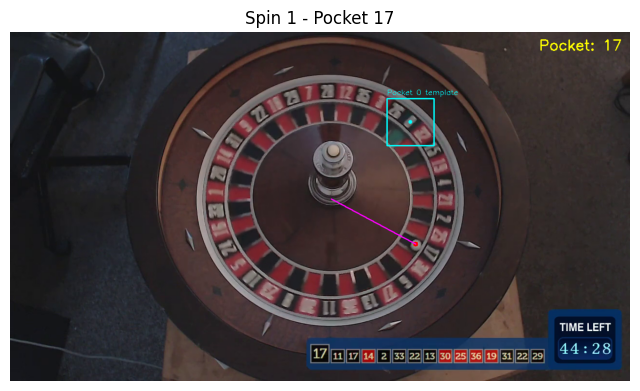

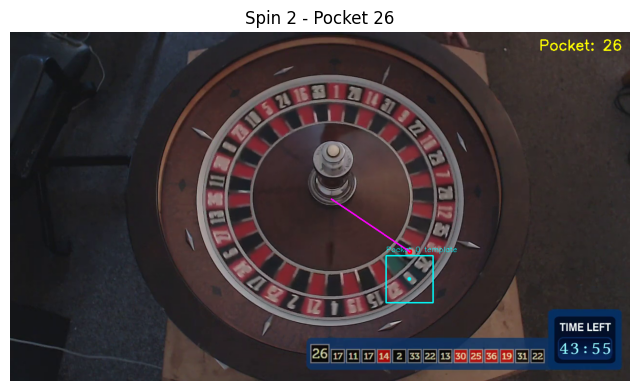

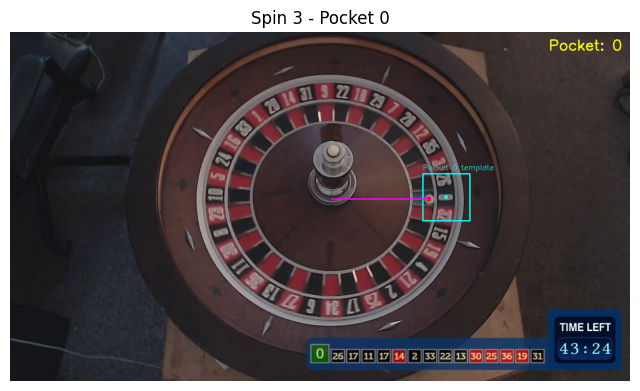

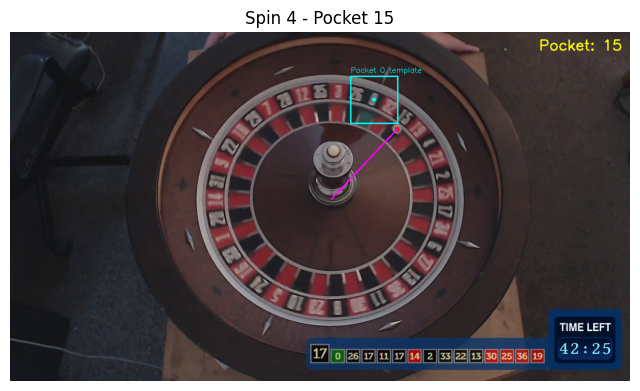

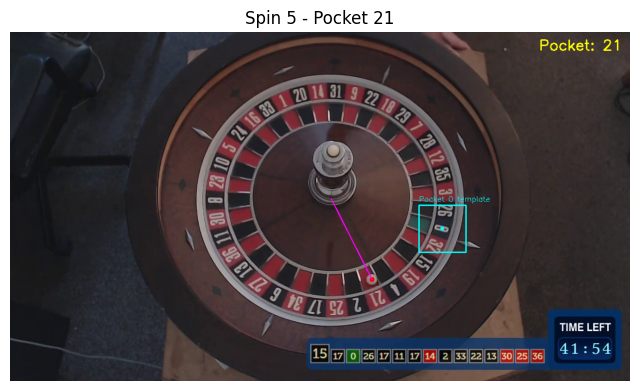

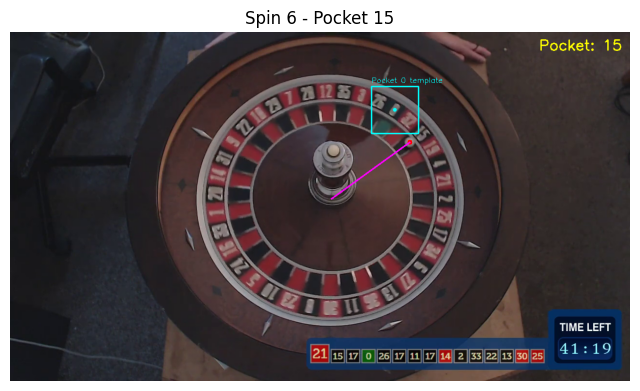

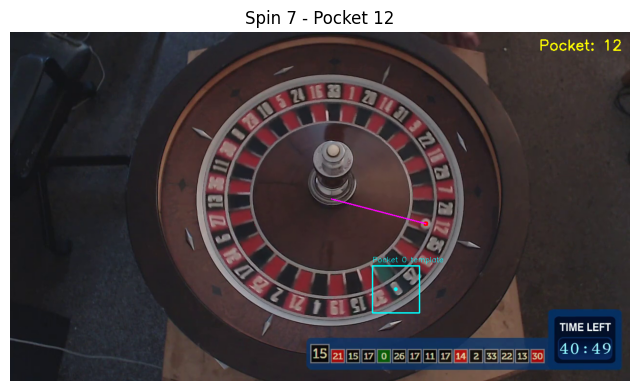

Detection screenshots saved to: C:\Users\Gabriel\Documents\Dissertation\Code\notebooks\roulette_cv4\pocket_detection_output\screenshots


In [24]:
# Save results to JSON
with open(RESULTS_JSONL_PATH, 'a', encoding="utf-8") as f:
    for event in results:
        f.write(json.dumps(event) + "\n")

print(f"Results saved to: {RESULTS_JSONL_PATH}")

# Create screenshots output directory
screenshots_output_dir = Path(OUTPUT_DIR) / "screenshots"
screenshots_output_dir.mkdir(parents=True, exist_ok=True)

# Save one detection visualization per spin
for result in results:
    if result['pocket_number'] is None:
        continue

    shot_details = result.get("shot_details") or []
    chosen = None
    for detail in shot_details:
        if detail.get("pocket_number") == result["pocket_number"]:
            chosen = detail
            break
    if chosen is None:
        for detail in shot_details:
            if detail.get("screenshot") is not None:
                chosen = detail
                break
    if chosen is None:
        continue

    screenshot_path = screenshot_dir / chosen["screenshot"]
    output_path = screenshots_output_dir / f"spin_{result['spin_id']}_{chosen['screenshot']}"
    ball_position = chosen.get("ball_position")
    if ball_position is None:
        continue

    img = visualize_detection(
        screenshot_path,
        ball_position[0],
        ball_position[1],
        result['pocket_number'],
        geometry,
        output_path,
        zero_bbox=tuple(chosen['zero_bbox']) if chosen.get('zero_bbox') else None,
        zero_center=tuple(chosen['zero_center']) if chosen.get('zero_center') else None,
    )

    plt.figure(figsize=(8, 5))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f"Spin {result['spin_id']} - Pocket {result['pocket_number']}")
    plt.axis('off')
    plt.show()

print(f"Detection screenshots saved to: {screenshots_output_dir.resolve()}")